# Portfolio Optimization with Evolutionary Algorithms

---

**Project Goal:** Optimize a stock portfolio from the WIG20 index using classical Markowitz theory and Evolutionary Algorithms.

**Authors:** Wojciech Fiołka (fiolkawojciech@gmail.com), Igor Jakus (igorjakus@protonmail.com)


## 0. Wczytanie danych rynkowych


In [1]:
import numpy as np
import yfinance as yf
from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [2]:
WIG20_TICKERS = sorted(
    [
        "ALR.WA",
        "ALE.WA",
        "ASB.WA",
        "BDX.WA",
        "CDR.WA",
        "CPS.WA",
        "DNP.WA",
        "JSW.WA",
        "KGH.WA",
        "KRU.WA",
        "LPP.WA",
        "MBK.WA",
        "OPL.WA",
        "PCO.WA",
        "PEP.WA",
        "PGE.WA",
        "PKN.WA",
        "PKO.WA",
        "PZU.WA",
        "SPL.WA",
    ]
)


def load_data(tickers, start="2020-01-01"):
    """Fetches WIG20 data. Uses Adjusted Close for returns as it accounts for dividends and splits."""
    data = yf.download(tickers, start=start, progress=False, auto_adjust=True)
    if data is None or data.empty:
        raise ValueError("No data fetched. Please check the tickers and date range.")
    return data


stock_names = np.array(WIG20_TICKERS)
full_data = load_data(WIG20_TICKERS)

prices = full_data["Close"].ffill()  # fill missing data with forward fill
prices.tail()

Ticker,ALE.WA,ALR.WA,ASB.WA,BDX.WA,CDR.WA,CPS.WA,DNP.WA,JSW.WA,KGH.WA,KRU.WA,LPP.WA,MBK.WA,OPL.WA,PCO.WA,PEP.WA,PGE.WA,PKN.WA,PKO.WA,PZU.WA,SPL.WA
Date,,,,,,,,,,,,,,,,,,,,
2025-12-22,30.959999,111.800003,31.600000,640.799988,245.800003,11.130,40.790001,21.840000,272.399994,492.700012,21180.0,1058.0,9.998,29.520000,54.400002,8.640,94.870003,84.820000,67.900002,544.000000
2025-12-23,30.625000,111.050003,31.620001,636.799988,240.100006,12.290,40.950001,22.240000,273.799988,492.299988,20770.0,1060.0,9.976,29.700001,53.799999,8.640,93.889999,84.440002,67.500000,542.400024
2025-12-29,31.195000,110.349998,32.900002,639.799988,241.500000,12.355,41.349998,22.730000,273.100006,492.000000,20800.0,1053.5,10.020,29.990000,54.200001,8.768,95.620003,84.620003,66.080002,543.799988
2025-12-30,31.020000,110.449997,32.880001,637.799988,241.000000,12.200,41.349998,23.400000,280.799988,493.500000,20810.0,1061.5,10.190,30.000000,53.200001,8.804,96.110001,85.160004,66.739998,545.400024
2026-01-02,31.245001,114.099998,32.680000,641.599976,241.699997,12.820,41.000000,23.450001,283.500000,498.399994,21200.0,1099.0,10.210,30.980000,55.599998,9.100,101.300003,87.959999,68.500000,560.200012


## 1. Notowania spółek giełdowych


In [3]:
def plot_close_price(stock_name):
    ts = prices[stock_name].dropna()

    plt.figure(figsize=(12, 6))
    plt.plot(ts.index, ts.values, color="steelblue", linewidth=2)
    plt.title(f"Notowania: {stock_name}", fontsize=14)
    plt.xlabel("Data", fontsize=12)
    plt.ylabel("Cena zamknięcia", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


ui_plot = interactive(plot_close_price, stock_name=stock_names)
display(ui_plot)

interactive(children=(Dropdown(description='stock_name', options=(np.str_('ALE.WA'), np.str_('ALR.WA'), np.str…

## 2. Stopy zwrotu spółek giełdowych


Rozpatrujemy $d$ spółek giełdowych, $\mathcal{A}_1, \mathcal{A}_2, \ldots, \mathcal{A}_d$. Niech $v^i_t$ oznacza wartość akcji spółki $\mathcal{A}_i$ w dniu $t$ (dla celów obliczeniowych, przyjmujemy, że wartość akcji jest określana przez cenę zamknięcia). _Stopą zwrotu_ spółki $\mathcal{A}_i$ w dniu $t$ nazywamy $$r^i_t = \frac{v^i_t - v^i_{t-1}}{v^i_{t-1}}.$$

Niech $t_0$ będzie ustalonym przyszłym dniem. Zakładamy w związku z tym, że nie mamy informacji o notowaniach spółek giełdowych w dniu $t_0$, ale znamy notowania z dni poprzednich. Stopę zwrotu spółki $\mathcal{A}_i$ w dniu $t_0$ traktujemy więc jako zmienną losową, oznaczmy ją przez $R_i$, i możemy określić oczekiwaną stopę zwrotu $\mathbb{E}[R_i]$ oraz wariancję stopy zwrotu $\mathbb{Var}[R_i]$ estymując je na okresie ostatnich $\Delta t$ dni, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$. Analogicznie, oznaczając przez $\mathbf{R} = (R_1, R_2, \ldots, R_d)^T$ wektor losowy stóp zwrotu wszystkich rozpatrywanych spółek, możemy określić kowariancje $\mathbb{Cov}[\mathbf{R}]$ i korelacje $\mathbb{Corr}[\mathbf{R}]$ stóp zwrotu. Zatem:

- oczekiwaną stopę zwrotu $\mathbb{E}[R_i]$ spółki $\mathcal{A}_i$ w dniu $t_0$ definiujemy jako średnią stopą zwrotu z ostatnich $\Delta t$ dni, czyli z okresu $[t_0 - \Delta t, t_0 - 1]$,

- wariancję $\mathbb{Var}[R]$ spółki $\mathcal{A}_i$ w dniu $t_0$ definiujemy jako wariancję na ostatnich $\Delta t$ dniach, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$,

- zależności między spółkami w dniu $t_0$ określamy przez kowariancję/korelację ich stóp zwrotu na ostatnich $\Delta t$ dniach, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$.

<hr>
<b>UWAGA:</b> Przez <i>dzień</i> rozumiem tutaj <i>dzień roboczy</i>, a nie <i>dzień kalendarzowy</i>. Prowadzi to do pewnych nieścisłości (stopa zwrotu dla poniedziałku to de facto trzydniowa stopa zwrotu), bo tak liczone stopy zwrotu różnią się od stóp zwrotu liczonych zazwyczaj dla instrumentów pozbawionych ryzyka, m.in. lokat bankowych, gdzie oprocentowanie liczy się dla wszystkich dni kalendarzowych.

<hr>
Poniższe przykładowe obliczenia ilustrują estymowanie oczekiwanej stopy zwrotu i wariancji dla ostatniego dnia zarejestrowanych notowań.


In [4]:
delta_t = 90
stock_returns = prices.pct_change()

# only delta_t days before the last day
analysis_period = stock_returns.iloc[-delta_t - 1 : -1]

stock_returns_m = analysis_period.mean()
stock_returns_s = analysis_period.std()
stock_covariances = analysis_period.cov()
stock_correlations = analysis_period.corr()

### 2.1. Oczekiwana stopa zwrotu i ryzyko (określone przez wariancję stopy zwrotu) rozpatrywanych spółek


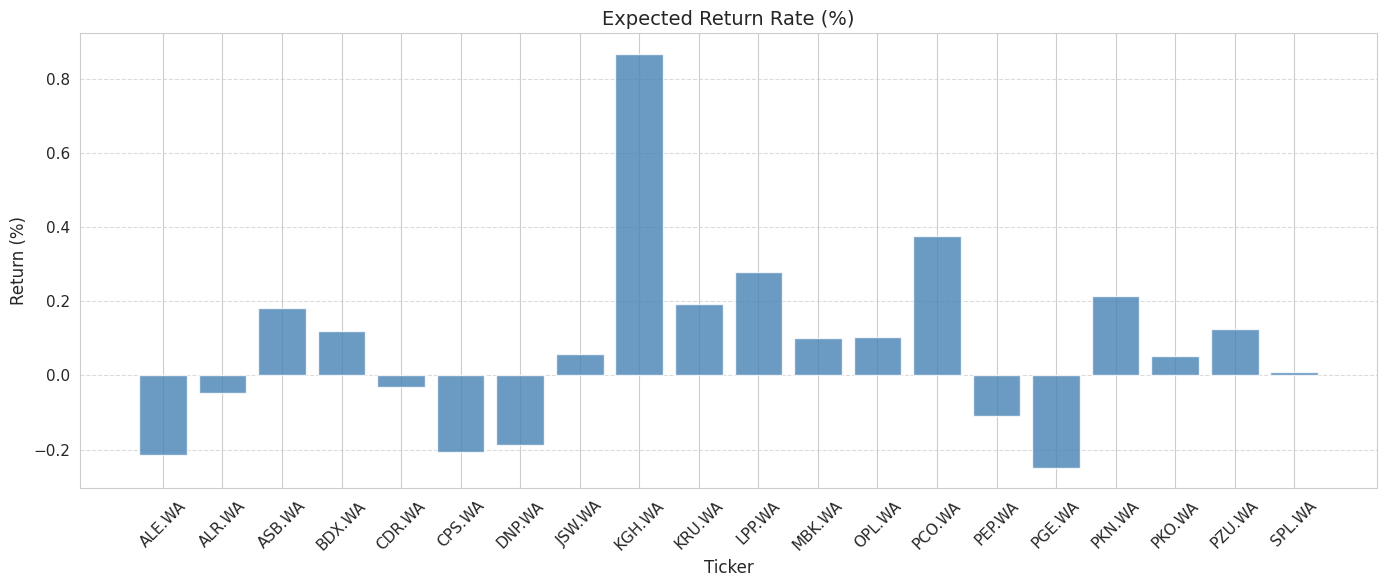

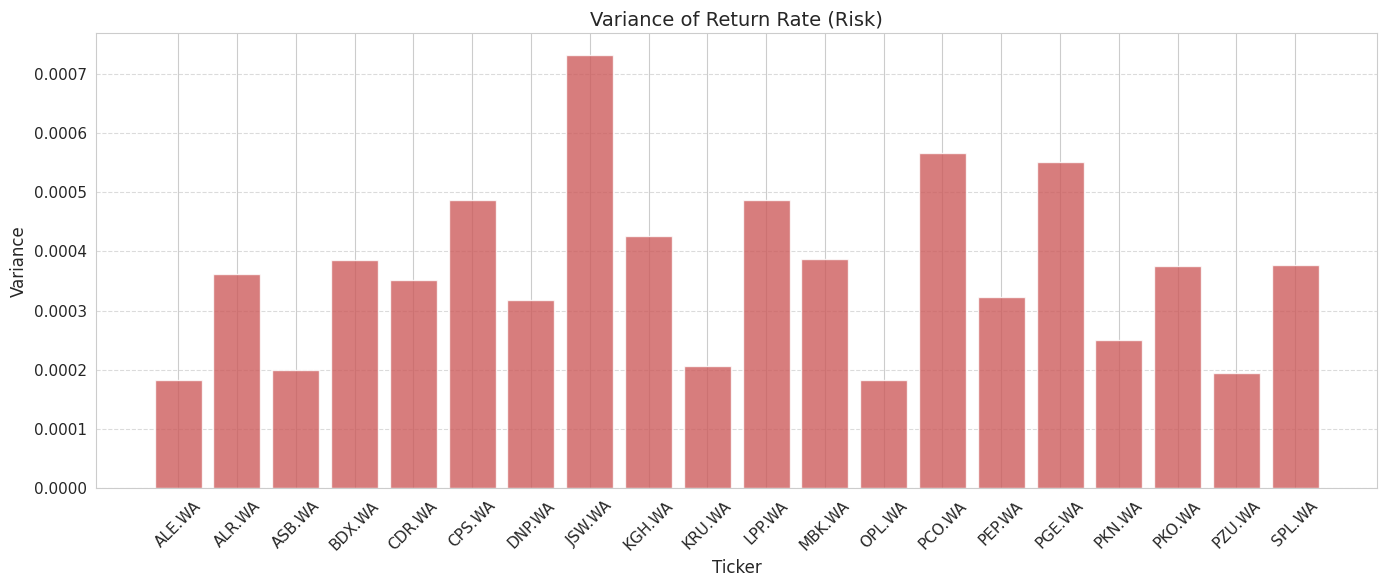

In [5]:
# expected return
plt.figure(figsize=(14, 6))
plt.bar(stock_returns_m.index, 100.0 * stock_returns_m, color="steelblue", alpha=0.8)
plt.title("Expected Return Rate (%)", fontsize=14)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Return (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# variance
plt.figure(figsize=(14, 6))
plt.bar(stock_returns_s.index, stock_returns_s**2, color="indianred", alpha=0.8)
plt.title("Variance of Return Rate (Risk)", fontsize=14)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Variance", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### 2.2. Korelacja stóp zwrotu rozpatrywanych spółek


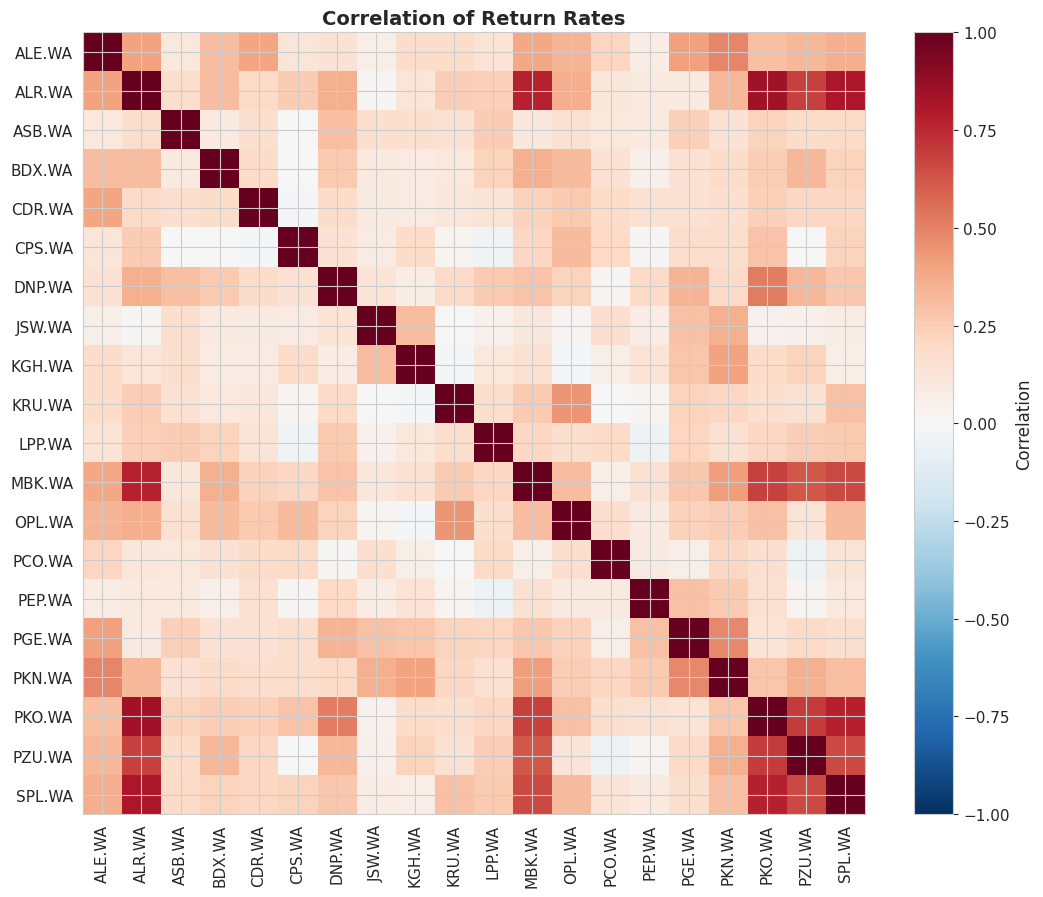

In [6]:
fig, ax = plt.subplots(figsize=(11, 9))
im = ax.imshow(stock_correlations, cmap="RdBu_r", interpolation="nearest", vmin=-1, vmax=1)
cbar = plt.colorbar(im, ax=ax, label="Correlation")
ax.set_xticks(range(len(stock_correlations.columns)))
ax.set_yticks(range(len(stock_correlations.columns)))
ax.set_xticklabels(stock_correlations.columns, rotation=90)
ax.set_yticklabels(stock_correlations.columns)
ax.set_title("Correlation of Return Rates", fontweight="bold")
plt.tight_layout()
plt.show()

### 2.3. Spółki dominujące, zdominowane i niezdominowane

Zastanawiając się w którą spółkę giełdową zainwestować kapitał, rozważamy dwa parametry: oczekiwaną stopę zwrotu inwestycji oraz ryzyko inwestycji (definiowane przez wariancję stopy zwrotu). Rozpatrując zbiór spółek giełdowych, można wprowadzić pojęcia _spółki dominującej_ i _spółki zdominowanej_ w następujący sposób:

- Mówimy, że spółka giełdowa $\mathcal{A}$ dominuje spółkę giełdową $\mathcal{B}$, jeżeli oczekiwana stopa zwrotu spółki $\mathcal{A}$ jest nie niższa niż spółki $\mathcal{B}$ oraz ryzyko spółki $\mathcal{A}$ jest niższe niż ryzyko spółki $\mathcal{B}$ .
- Spółka $\mathcal{B}$ jest spółką zdominowaną, jeśli istnieje spółka $\mathcal{A}$, która ją dominuje.
- Spółka $\mathcal{B}$ jest spółką niezdominowaną, jeśli nie istnieje spółka $\mathcal{A}$, która ją dominuje.


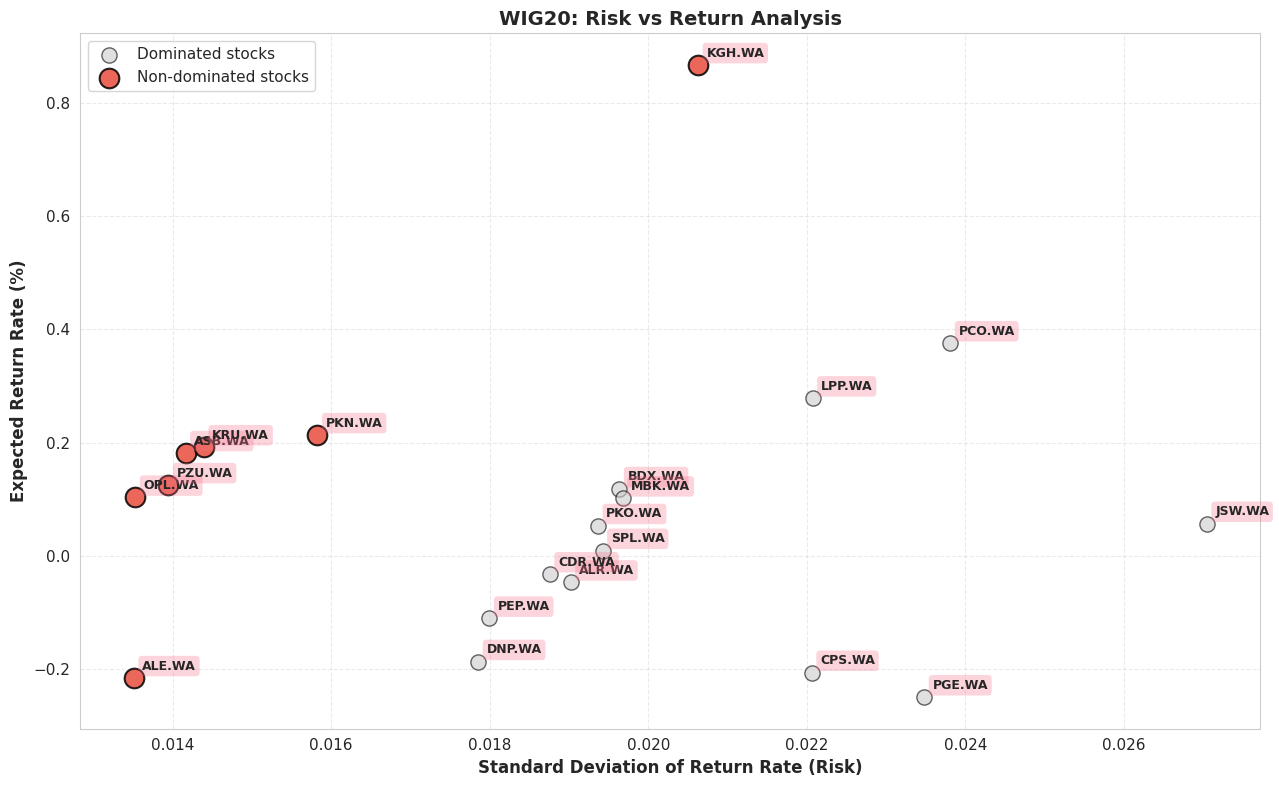

In [8]:
is_dominated = np.zeros(stock_returns_m.size)
for i in range(stock_returns_m.size):
    for j in range(stock_returns_m.size):
        if (
            (i != j)
            and (stock_returns_m.iloc[i] <= stock_returns_m.iloc[j])
            and (stock_returns_s.iloc[i] > stock_returns_s.iloc[j])
        ):
            is_dominated[i] = 1
            break

fig, ax = plt.subplots(figsize=(13, 8))

# Spółki zdominowane
ax.scatter(
    stock_returns_s[is_dominated == 1],
    100.0 * stock_returns_m[is_dominated == 1],
    color="#cccccc",
    alpha=0.6,
    label="Dominated stocks",
    s=120,
    edgecolors="black",
    linewidth=1,
)

# Spółki niezdominowane
ax.scatter(
    stock_returns_s[is_dominated == 0],
    100.0 * stock_returns_m[is_dominated == 0],
    color="#e74c3c",
    alpha=0.85,
    label="Non-dominated stocks",
    s=200,
    edgecolors="black",
    linewidth=1.5,
)

# Dodanie etykiet spółek
for i, txt in enumerate(stock_returns_m.index):
    ax.annotate(
        txt,
        (stock_returns_s.iloc[i], 100.0 * stock_returns_m.iloc[i]),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3, edgecolor="none"),
    )

ax.set_title("WIG20: Risk vs Return Analysis", fontweight="bold")
ax.set_xlabel("Standard Deviation of Return Rate (Risk)", fontweight="bold")
ax.set_ylabel("Expected Return Rate (%)", fontweight="bold")
ax.legend(fontsize=11, loc="upper left")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## 3. Teoria portfela Markowitza


Zamiast zastanawiać się w którą spółkę giełdową zainwestować cały kapitał, można zastanawiać się jak podzielić rozpatrywany kapitał na części i zainwestować je w poszczególne spółki (stworzyć _portfel_ inwestycji).


### 3.1. Wprowadzenie

Niech $\mathbf{R} = (R_1, R_2, \ldots, R_d)^T$ oznacza wektor losowy stóp zwrotu wszystkich rozpatrywanych spółek.

Niech $\boldsymbol{\mu} = (\mu_1, \mu_2, \ldots, \mu_d)^T = \mathbb{E}[\mathbf{R}] \in \mathbb{R}^d$ oznacza wektor oczekiwanych stóp zwrotu rozpatrywanych spółek.

Niech $\boldsymbol{\Sigma} = \mathbb{Cov}[\mathbf{R}] \in \mathbb{R}^{d \times d}$ oznacza macierz kowariancji stóp zwrotu rozpatrywanych spółek.

Zakładamy, że rozpatrywane spółki są instrumentami obarczonymi ryzykiem, czyli wariancja ich stóp zwrotu jest niezerowa (dokładniej: zakładamy, że macierz kowariancji $\boldsymbol{\Sigma}$ jest dodatnio określona - skąd wynika, że jest macierzą odwracalną).

_Portfelem_ nazywamy wektor $\mathbf{p} = (p_1, p_2, \ldots, p_d)^T \in \mathbb{R}^d$, taki że $\sum_{i=1}^d p_i = 1$, który definiuje rozbicie kapitału na części do zainwestowania w poszczególne spółki ($p_i$ to wielkość kapitału do zainwestowania w spółkę $\mathcal{A}_i$).

Stopa zwrotu portfela $\mathbf{p}$ jest więc zmienną losową $R_\mathbf{p} = \mathbf{p}^T \mathbf{R}$.

Oczekiwana stopa zwrotu portfela wynosi zatem $\mathbb{E}[R_\mathbf{p}] = \mathbb{E}[\mathbf{p}^T \mathbf{R}] = \mathbf{p}^T \mathbb{E}[\mathbf{R}] = \mathbf{p}^T \boldsymbol{\mu}$.

Ryzyko portfela, określone przez wariancję jego stopy zwrotu, wynosi zatem $\mathbb{Var}[R_\mathbf{p}] = \mathbb{Var}[\mathbf{p}^T \mathbf{R}] = \mathbf{p}^T \mathbb{Cov}[\mathbf{R}] \mathbf{p} = \mathbf{p}^T \boldsymbol{\Sigma} \mathbf{p}$.


<div style="background-color:rgba(0, 0, 0, 0.15)">
<b>UWAGA</b>: Powyższe podejście teoretyczne nie pokrywa się z podejściem obliczeniowym (wartość oczekiwana i wariancja stopy zwrotu portfela estymowana na podstawie jego wartości w ustalonym okresie nie pokrywają się z wartościami liczonymi według powyższych wzorów).

Pozornie, dla ustalonego dnia $t_0$, oczekiwaną stopę zwrotu portfela (i analogicznie jej wariancję), można byłoby określić estymując je na okresie ostatnich $\Delta t$ dni, czyli na okresie $[t_0 - \Delta t + 1, t_0]$.

Portfel definuje jaka część całkowitego kapitału (domyślnie równego 1) jest inwestowana w poszczególne spółki: w $i$-tą spółkę inwestowane jest $p_i$, czyli kupowane jest $\frac{p_i}{v^i_{t_0}}$ akcji tej spółki. Zatem, całkowita wartość takiego portfela w dniu $t$ wynosiła $$\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_t,$$ czyli stopa zwrotu takiego portfela w dniu $t$ wynosiła $$\frac{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_t - \sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}}{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}} = \frac{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} (v^i_t - v^i_{t-1})}{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}} = \frac{\sum_{i=1}^d p_i r^i_t \frac{v^i_{t-1}}{v^i_{t_0}}}{\sum_{i=1}^d p_i \frac{v^i_{t-1}}{v^i_{t_0}}} \approx \frac{\sum_{i=1}^d p_i r^i_t}{\sum_{i=1}^d p_i} = \sum_{i=1}^d p_i r^i_t,$$ o ile $\frac{v^i_{t-1}}{v^i_{t_0}}$ jest bliskie $1$.

Jeśli $t$ byłoby równe $t_0 + 1$, to oczywiście równość zachodziłaby. W przeciwnym przypadku możemy otrzymać rozbieżność między bezpośrednio estymowaną oczekiwaną stopą zwrotu portfela, a oczekiwaną stopą zwrotu portfela wyliczoną z modelu zawierającego estymowane statystyki stóp zwrotu rozpatrywanych spółek.

Rozbieżność ta wynika z faktu, że próbujemy przekształcić portfel wyrażający procentowy udział poszczególnych spółek w całkowitym kapitale portfela na liczbę akcji poszczególnych spółek, a ze względu na zmiany cen akcji w czasie, ustalenie konkretnej liczby akcji w wybranym dniu $t_0$ może powodować zmiany procentowego udziału poszczególnych spółek w całkowitym kapitale portfela w czasie. Innymi słowy, w rozpatrywanej wyżej estymacji, w dniach $t \neq t_0$ analizowaliśmy portfel nie będący portfelem $\mathbf{p}$!

</div>


### 3.2. Optymalizacja portfela

_Portfel optymalny_ to portfel minimalizujący ryzyko dla ustalonej oczekiwanej stopy zwrotu. Można go formalnie określić jako rozwiązanie problemu optymalizacji funkcji
$$\frac{1}{2} \mathbf{p}^T \boldsymbol{\Sigma} \mathbf{p}$$ z ograniczeniami $$\mathbf{p}^T \boldsymbol{\mu} = e,
\quad
\mathbf{p}^T \mathbf{1} = 1,$$
gdzie $e$ jest ustaloną oczekiwaną stopą zwrotu portfela.

Stosując metodę mnożników Lagrange'a, można rozwiązać ten problem analitycznie otrzymując rozwiązanie [1]:

$$
\mathbf{p} = \frac{1}{D} ((e C - A) \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} + (B - e A) \boldsymbol{\Sigma}^{-1} \mathbf{1}) = \frac{1}{D} (B \boldsymbol{\Sigma}^{-1} \mathbf{1} - A \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}) +
e \frac{1}{D} ((C \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - A \boldsymbol{\Sigma}^{-1} \mathbf{1}),
$$

gdzie

$$
A = \boldsymbol{\mu}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}, \qquad
B = \boldsymbol{\mu}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}, \qquad
C = \mathbf{1}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}, \qquad
D = B C - A^2.
$$

Rozwiązania problemu optymalizacji portfela można przedstawić jako
$$\mathbf{p} = \mathbf{p}_1 + e \mathbf{p}_2,$$
gdzie

$$
\mathbf{p}_1 = \frac{1}{D} (B \boldsymbol{\Sigma}^{-1} \mathbf{1} - A \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}),
\qquad
\mathbf{p}_2 = \frac{1}{D} ((C \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - A \boldsymbol{\Sigma}^{-1} \mathbf{1}).
$$


In [9]:
def optimize_markowitz(returns_m, covariances, n_portfolios=1000):
    """
    Calculates the efficient frontier using the analytical Markowitz solution.
    Returns: (weights, expected_returns, volatilities)
    """
    d = returns_m.size
    Sinv = np.linalg.inv(covariances)
    ones = np.ones(d)

    A = returns_m.T.dot(Sinv.dot(ones))
    B = returns_m.T.dot(Sinv.dot(returns_m))
    C = ones.T.dot(Sinv.dot(ones))
    D = B * C - A**2

    p1 = 1 / D * (B * Sinv.dot(ones) - A * Sinv.dot(returns_m))
    p2 = 1 / D * (C * Sinv.dot(returns_m) - A * Sinv.dot(ones))

    # Generate portfolios along the frontier
    # 0.0001 is a step for the expected return multiplier
    portfolios = np.array([p1 + 0.0001 * i * p2 for i in range(n_portfolios)]).T

    p_m = portfolios.T.dot(returns_m)
    p_s = np.sqrt(np.diag(portfolios.T.dot(covariances.dot(portfolios))))

    return portfolios, p_m, p_s


p, p_m, p_s = optimize_markowitz(stock_returns_m, stock_covariances)

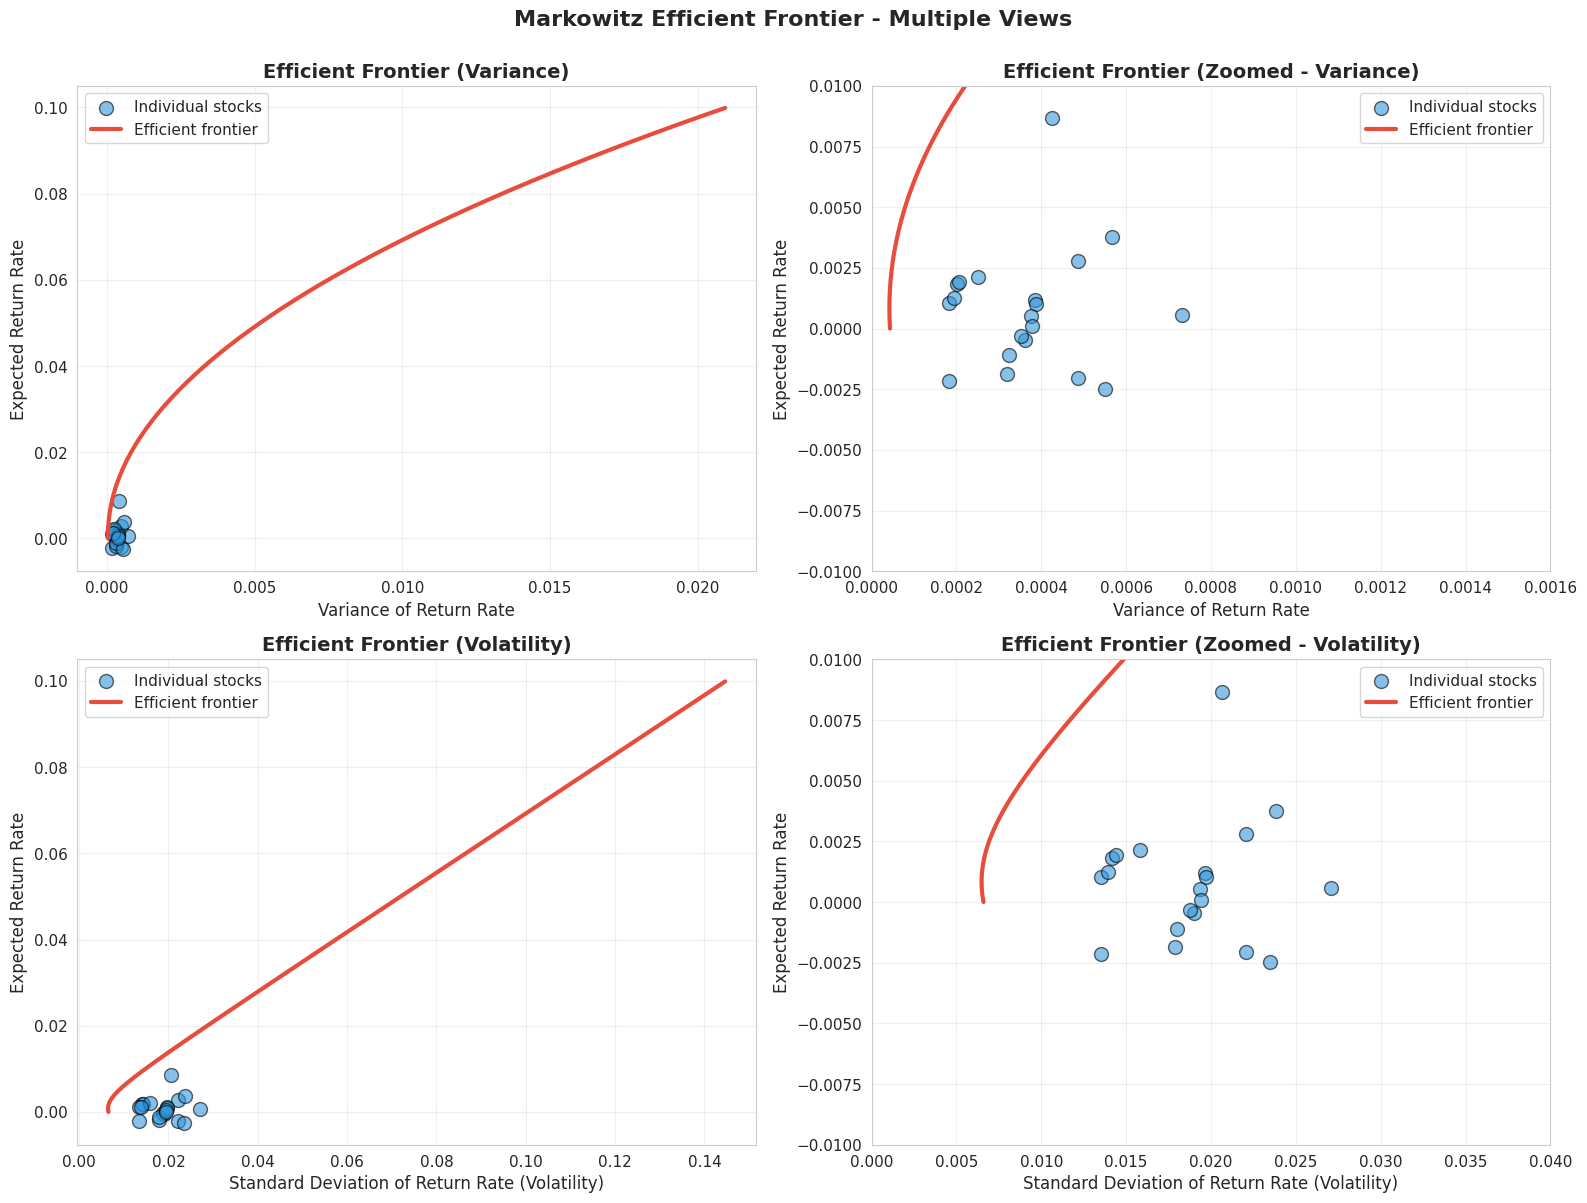

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top-left: Variance vs Return (full range)
axes[0, 0].scatter(
    stock_returns_s**2,
    stock_returns_m,
    color="#3498db",
    s=100,
    alpha=0.6,
    edgecolors="black",
    label="Individual stocks",
)
axes[0, 0].plot(p_s**2, p_m, color="#e74c3c", linewidth=3, label="Efficient frontier")
axes[0, 0].set_xlabel("Variance of Return Rate")
axes[0, 0].set_ylabel("Expected Return Rate")
axes[0, 0].set_title("Efficient Frontier (Variance)", fontweight="bold")
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Top-right: Variance vs Return (zoomed)
axes[0, 1].scatter(
    stock_returns_s**2,
    stock_returns_m,
    color="#3498db",
    s=100,
    alpha=0.6,
    edgecolors="black",
    label="Individual stocks",
)
axes[0, 1].plot(p_s**2, p_m, color="#e74c3c", linewidth=3, label="Efficient frontier")
axes[0, 1].set_xlim([0, 0.0016])
axes[0, 1].set_ylim([-0.01, 0.01])
axes[0, 1].set_xlabel("Variance of Return Rate")
axes[0, 1].set_ylabel("Expected Return Rate")
axes[0, 1].set_title("Efficient Frontier (Zoomed - Variance)", fontweight="bold")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Bottom-left: Volatility vs Return (full range)
axes[1, 0].scatter(
    stock_returns_s, stock_returns_m, color="#3498db", s=100, alpha=0.6, edgecolors="black", label="Individual stocks"
)
axes[1, 0].plot(p_s, p_m, color="#e74c3c", linewidth=3, label="Efficient frontier")
axes[1, 0].set_xlabel("Standard Deviation of Return Rate (Volatility)")
axes[1, 0].set_ylabel("Expected Return Rate")
axes[1, 0].set_title("Efficient Frontier (Volatility)", fontweight="bold")
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Bottom-right: Volatility vs Return (zoomed)
axes[1, 1].scatter(
    stock_returns_s, stock_returns_m, color="#3498db", s=100, alpha=0.6, edgecolors="black", label="Individual stocks"
)
axes[1, 1].plot(p_s, p_m, color="#e74c3c", linewidth=3, label="Efficient frontier")
axes[1, 1].set_xlim([0, 0.04])
axes[1, 1].set_ylim([-0.01, 0.01])
axes[1, 1].set_xlabel("Standard Deviation of Return Rate (Volatility)")
axes[1, 1].set_ylabel("Expected Return Rate")
axes[1, 1].set_title("Efficient Frontier (Zoomed - Volatility)", fontweight="bold")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.suptitle("Markowitz Efficient Frontier - Multiple Views", fontsize=16, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

In [11]:
def plot_portfolio_composition(weights, names, title="Skład portfela"):
    """
    Plots the composition of a single portfolio.
    """
    # Filtrowanie małych wag dla czytelności wykresu
    mask = np.abs(weights) > 0.01
    filtered_weights = weights[mask]
    filtered_names = names[mask]

    fig, ax = plt.subplots(figsize=(14, 7))

    # Gradient colors
    colors = sns.color_palette("husl", len(filtered_weights))
    bars = ax.bar(filtered_names, filtered_weights * 100, color=colors, edgecolor="black", linewidth=1)

    # Dodanie wartości nad słupkami
    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.3,
            f"{yval:.2f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_title(title, fontweight="bold", fontsize=14)
    ax.set_xlabel("Stock (Ticker)", fontweight="bold")
    ax.set_ylabel("Weight (%)", fontweight="bold")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", alpha=0.3)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def plot_markowitz_portfolio_composition(portfolio_idx):
    """
    Interactive wrapper for plotting Markowitz portfolios.
    """
    clear_output(wait=True)
    plt.close("all")

    weights = p[:, portfolio_idx]
    title = (
        f"Skład portfela Markowitza nr {portfolio_idx}\n"
        f"(Zwrot: {p_m[portfolio_idx] * 100:.3f}%, Ryzyko: {p_s[portfolio_idx] * 100:.3f}%)"
    )

    plot_portfolio_composition(weights, stock_names, title=title)


ui_portfolio = interactive(plot_markowitz_portfolio_composition, portfolio_idx=(0, len(p_m) - 1, 1))
display(ui_portfolio)

interactive(children=(IntSlider(value=499, description='portfolio_idx', max=999), Output()), _dom_classes=('wi…

## 4. Teoria portfela w praktyce

W ostatnich latach powstaje wiele rozszerzeń klasycznej teorii portfela, które często prowadzą do problemów optymalizacji wymagających złożonych algorytmów rozwiązywania. Wiele modeli wprowadza inne niż wariancja miary ryzyka (m.in. semiwariancja). Wiele modeli odrzuca też założenie o braku ograniczeń _krótkiej sprzedaży_ (ang. short sale), czyli możliwości posiadania ujemnej liczby akcji (w klasycznej teorii portfela dopuszcza się, że współrzędne $p_i$ portfela mogą być ujemne).


## 5. Algorytmy Ewolucyjne


In [ ]:
def semivariance(returns: np.ndarray):
    """Calculates semivariance

    Args:
        returns (np.ndarray): Return rates
    Returns:
        float: Variance of negative deviations from the mean
    """
    mean_return = np.mean(returns)
    negative_deviations = returns[returns < mean_return] - mean_return
    return np.var(negative_deviations)


def normalize_weights(weights: np.ndarray) -> np.ndarray:
    """Normalizes portfolio weights to sum to 1.

    Args:
        weights (np.ndarray): Portfolio weights, shape (pop_size, n_assets)
    Returns:
        np.ndarray: Normalized portfolio weights, shape (pop_size, n_assets)
    """
    total = np.sum(weights, axis=1, keepdims=True)
    if np.any(total == 0):
        raise ValueError("Sum of weights is zero, cannot normalize.")
    return weights / total


def is_valid_portfolio(weights: np.ndarray, min_weight=0.0, max_weight=1.0, max_cardinality=None, epsilon=1e-6):
    """Checks if the portfolio weights sum to 1 and satisfy all constraints.

    Args:
        weights (np.ndarray): Portfolio weights
        min_weight (float, optional): Minimum allowed weight for non-zero assets. Defaults to 0.0.
        max_weight (float, optional): Maximum allowed weight for each asset. Defaults to 1.0.
        max_cardinality (int, optional): Maximum number of assets in portfolio. Defaults to None.
        epsilon (float, optional): Tolerance for treating weights as zero. Defaults to 1e-6.

    Returns:
        bool: True if valid, False otherwise

    Notes:
        - Weights with |w| <= epsilon are treated as "not selected" and exempt from min/max checks
        - Such weights may be slightly negative due to numerical errors - this is acceptable
        - Only |weights| > epsilon are validated against min_weight and max_weight constraints
    """
    nonzero_mask = np.abs(weights) > epsilon

    return (
        np.isclose(np.sum(weights), 1.0)
        and np.all(weights[nonzero_mask] >= min_weight)
        and np.all(weights[nonzero_mask] <= max_weight)
        and (max_cardinality is None or np.sum(nonzero_mask) <= max_cardinality)
    )


def calculate_portfolio_return(weights: np.ndarray, returns_m: np.ndarray):
    """Calculates expected return of the portfolio.

    Args:
        weights (np.ndarray): Portfolio weights
        returns_m (np.ndarray): Expected returns of individual assets
    Returns:
        float: Expected return of the portfolio
    """
    return np.dot(weights, returns_m)

In [ ]:
def tournament_selection(fitnesses: np.ndarray, offspring_size: int, tournament_size=3):
    """Selects individuals from the population using tournament selection.

    Args:
        fitnesses (np.ndarray): Fitness values of individuals
        offspring_size (int): Number of individuals to select
        tournament_size (int, optional): Number of individuals in each tournament. Defaults to 3.
    Returns:
        np.ndarray: Selected individuals indices
    """
    pop_size = fitnesses.shape[0]

    # generate random indices for candidates in each tournament
    candidates_indices = np.random.randint(0, pop_size, (offspring_size, tournament_size))
    candidates_fitnesses = fitnesses[candidates_indices]

    # find the winner (index of the best candidate) in each tournament
    winners_local_indices = np.argmin(candidates_fitnesses, axis=1)

    # map local winner indices back to global population indices
    selected_indices = candidates_indices[np.arange(offspring_size), winners_local_indices]
    return selected_indices


def initialize_population(pop_size: int, n_assets: int, method="dirichlet"):
    """Initializes a population of portfolios with random weights.

    Args:
        pop_size (int): Population size
        n_assets (int): Number of assets in the portfolio
        method (str): Method to initialize weights ('uniform' or 'dirichlet')
    Returns:
        np.ndarray: Population of portfolios (shape: pop_size x n_assets)
    """
    if method == "uniform":
        population = np.random.rand(pop_size, n_assets)
        population = normalize_weights(population)
        return population
    elif method == "dirichlet":
        population = np.random.dirichlet(np.ones(n_assets), size=pop_size)
        return population
    else:
        raise ValueError("Unknown initialization method.")


def swap_mutation(population: np.ndarray, mutation_rate: float = 0.1) -> np.ndarray:
    """Applies swap mutation to the population (vectorized).

    Swaps the weights of two randomly selected assets for individuals that are selected for mutation.
    Returns a new mutated population without modifying the input.

    Args:
        population (np.ndarray): Population of portfolios (shape: pop_size x n_assets)
        mutation_rate (float): Probability of mutation for each individual. Defaults to 0.1.

    Returns:
        np.ndarray: Mutated population (new copy)

    Note:
        Preserves the sum-to-one constraint (swapping doesn't change total sum).
        Preserves min/max bounds and cardinality constraints *only if the input already satisfies them*.
        If input violates these constraints, swap will not fix them.
    """
    population = population.copy()  # Work on a copy to avoid modifying input
    # TODO: check whether it's detrimental to performance

    pop_size, n_assets = population.shape

    # Determine which individuals will be mutated
    mutation_mask = np.random.rand(pop_size) < mutation_rate
    mutation_indices = np.where(mutation_mask)[0]
    n_mutations = len(mutation_indices)

    if n_mutations == 0:
        return population

    # Generate pairs of random assets to swap
    asset1_indices = np.random.randint(0, n_assets, size=n_mutations)
    asset2_indices = np.random.randint(0, n_assets, size=n_mutations)

    # Ensure asset1 != asset2
    while np.any(asset1_indices == asset2_indices):
        bad_mask = asset1_indices == asset2_indices
        asset2_indices[bad_mask] = np.random.randint(0, n_assets, size=np.sum(bad_mask))

    # Perform swaps
    temp = population[mutation_indices, asset1_indices].copy()
    population[mutation_indices, asset1_indices] = population[mutation_indices, asset2_indices]
    population[mutation_indices, asset2_indices] = temp

    return population


def arithmetic_crossover(
    parent1: np.ndarray,
    parent2: np.ndarray,
    alpha: float = 0.5,
) -> tuple[np.ndarray, np.ndarray]:
    """Performs arithmetic crossover between two parent portfolios.

    Args:
        parent1 (np.ndarray): Weights of the first parent portfolio
        parent2 (np.ndarray): Weights of the second parent portfolio
        alpha (float): Crossover parameter (0 <= alpha <= 1). Defaults to 0.5.

    Returns:
        (np.ndarray, np.ndarray): Weights of the two offspring portfolios

    Note:
        Maintains key constraints when parents satisfy them:
        - Sum-to-one: if both parents sum to 1, offspring will also (since α·1 + (1-α)·1 = 1)
        - Min/max bounds: if all parent weights are in [min_w, max_w], offspring weights will be too
        - Does NOT preserve cardinality: offspring may have more non-zero weights than max_cardinality
          even if both parents respect the limit (due to convex combinations creating new non-zero entries)
    """
    offspring1 = alpha * parent1 + (1 - alpha) * parent2
    offspring2 = (1 - alpha) * parent1 + alpha * parent2
    return offspring1, offspring2

## References

[1] Markowitz, H., M., <a href='https://doi.org/10.2307/2975974'>Portfolio Selection</a>, <i>Journal of Finance<i>, vol.7, no.1, 1952, pp.77–91.
